In [14]:
# %% Cell 1: Import necessary libraries and set device
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and Torchvision imports
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import functional API for pooling
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# For TensorBoard logging
from torch.utils.tensorboard import SummaryWriter

# For computing the confusion matrix
from sklearn.metrics import confusion_matrix

# Set device (use GPU if available)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [2]:
# %% Cell 2: Load and preprocess CIFAR10 for the simple custom CNN
#
# For the custom model we use the native 32x32 images.
# We normalize the images to have pixel values in the range [-1, 1].
transform_simple = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),  # mean for R,G,B
                         (0.5, 0.5, 0.5))  # std for R,G,B
])

# Download CIFAR10 training and test sets
trainset_simple = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_simple)
testset_simple = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=True, transform=transform_simple)

# Create DataLoaders for training and test sets
trainloader_simple = torch.utils.data.DataLoader(trainset_simple, batch_size=64,
                                                 shuffle=True, num_workers=2)
testloader_simple = torch.utils.data.DataLoader(testset_simple, batch_size=64,
                                                shuffle=False, num_workers=2)

print("Simple model data loaded: train size =", len(trainset_simple),
      ", test size =", len(testset_simple))


Files already downloaded and verified
Files already downloaded and verified
Simple model data loaded: train size = 50000 , test size = 10000


In [3]:
# %% Cell 3: Define and train a simple custom CNN model
#
# The custom CNN has:
# - 2 convolutional layers (with ReLU and max pooling)
# - 2 fully connected layers.
# The forward() method returns both the logits and the "embedding" from the penultimate layer.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolution: input channels 3, output channels 32, kernel size 3, padding to keep size
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Second convolution: input channels 32, output channels 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Max pooling layer: reduces spatial dimensions by factor of 2
        self.pool = nn.MaxPool2d(2, 2)
        # After two poolings, the 32x32 image becomes 8x8 (32 -> 16 -> 8)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)  # penultimate layer (embedding)
        self.fc2 = nn.Linear(64, 10)          # output layer for 10 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        # Flatten the feature map
        x = x.view(x.size(0), -1)
        # Get the embedding from the first fully connected layer
        embedding = torch.relu(self.fc1(x))
        logits = self.fc2(embedding)
        return logits, embedding

# Initialize the custom CNN and move it to the device
simple_model = SimpleCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

# Train the custom CNN for a few epochs (e.g., 10 epochs)
num_epochs = 10
print("Training the simple custom CNN...")
for epoch in range(num_epochs):
    running_loss = 0.0
    simple_model.train()  # set model to training mode
    for inputs, labels in trainloader_simple:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()           # zero the parameter gradients
        outputs, _ = simple_model(inputs)  # forward pass (we ignore the embedding here)
        loss = criterion(outputs, labels)
        loss.backward()                 # backpropagation
        optimizer.step()                # update weights

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(trainset_simple)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Finished training the custom CNN.")


Training the simple custom CNN...
Epoch [1/10], Loss: 1.4217
Epoch [2/10], Loss: 1.0305
Epoch [3/10], Loss: 0.8961
Epoch [4/10], Loss: 0.8056
Epoch [5/10], Loss: 0.7377
Epoch [6/10], Loss: 0.6787
Epoch [7/10], Loss: 0.6202
Epoch [8/10], Loss: 0.5723
Epoch [9/10], Loss: 0.5242
Epoch [10/10], Loss: 0.4860
Finished training the custom CNN.


In [5]:
# %% Cell 4: Evaluate the simple custom CNN on the test set and extract embeddings
#
# We compute the accuracy on the test set and also store the embeddings for a subset
# of test samples (first 500) for later comparison.
simple_model.eval()  # set model to evaluation mode
correct = 0
total = 0

# To store embeddings and labels for the first 500 test samples
all_embeddings_simple = []
all_labels_simple = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader_simple):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, embeddings = simple_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Save embeddings and labels until we have 500 samples
        if len(all_embeddings_simple) < 500:
            all_embeddings_simple.append(embeddings.cpu())
            all_labels_simple.append(labels.cpu())
            
accuracy_simple = 100 * correct / total
print(f"Simple CNN Test Accuracy: {accuracy_simple:.2f}%")

# Concatenate embeddings and labels (only take the first 500 samples)
embeddings_custom = torch.cat(all_embeddings_simple, dim=0)[:500]
labels_custom = torch.cat(all_labels_simple, dim=0)[:500]


Simple CNN Test Accuracy: 71.42%


In [6]:
# %% Cell 5: Load and preprocess CIFAR10 for the pre‑trained model
#
# For MobileNetV2 the expected input size is 224x224 and normalization values
# are those used for ImageNet. We create new transforms for the pre‑trained model.
transform_pretrained = transforms.Compose([
    transforms.Resize(224),             # resize from 32x32 to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Download CIFAR10 with the new transform for training and testing
trainset_pretrained = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                   download=True, transform=transform_pretrained)
testset_pretrained = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                  download=True, transform=transform_pretrained)

# Create DataLoaders for the pre‑trained model
trainloader_pretrained = torch.utils.data.DataLoader(trainset_pretrained, batch_size=32,
                                                     shuffle=True, num_workers=2)
testloader_pretrained = torch.utils.data.DataLoader(testset_pretrained, batch_size=32,
                                                    shuffle=False, num_workers=2)

print("Pre-trained model data loaded: train size =", len(trainset_pretrained),
      ", test size =", len(testset_pretrained))


Files already downloaded and verified
Files already downloaded and verified
Pre-trained model data loaded: train size = 50000 , test size = 10000


In [15]:
# %% Cell 6: Build a pre‑trained MobileNetV2 model with a custom classifier head
#
# We load MobileNetV2 pre‑trained on ImageNet from Torchvision,
# freeze its feature extractor, replace its classifier head to output 10 classes,
# and wrap the model to return both logits and the embedding (features before the classifier).
from torchvision.models import mobilenet_v2

# Load MobileNetV2 with pre‑trained ImageNet weights
mobilenet = mobilenet_v2(pretrained=True)

# Freeze the feature extractor parameters (all layers in mobilenet.features)
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Replace the classifier head.
# The original classifier is: Sequential(Dropout, Linear(in_features=1280, out_features=1000))
# We replace it with a new linear layer for 10 classes.
num_features = mobilenet.last_channel  # typically 1280 for MobileNetV2
mobilenet.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 10)
)

# Define a wrapper model that returns both logits and the embedding.
# Define a custom wrapper to return both logits and the embedding
class PretrainedMobileNetV2(torch.nn.Module):
    def __init__(self, base_model):
        super(PretrainedMobileNetV2, self).__init__()
        self.base_model = base_model
        
    def forward(self, x):
        # Pass input through the feature extractor
        x = self.base_model.features(x)
        # Global average pooling using torch's built-in function:
        # This pools the spatial dimensions to (1,1) regardless of input size.
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # Flatten the pooled features to form the embedding
        x = torch.flatten(x, 1)
        embedding = x  # The resulting pooled and flattened feature vector.
        # Pass the embedding through the classifier head to get logits.
        logits = self.base_model.classifier(embedding)
        return logits, embedding

# Wrap the MobileNetV2 model
pretrained_model = PretrainedMobileNetV2(mobilenet).to(device)

# Define loss function and optimizer (only parameters with requires_grad=True will be updated)
criterion_pretrained = nn.CrossEntropyLoss()
optimizer_pretrained = optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=0.00001)

# Train only the classifier head (feature extractor is frozen) for a few epochs (e.g., 10 epochs)
num_epochs_pretrained = 10
print("Training the pre‑trained (frozen base) model...")
pretrained_model.train()
for epoch in range(num_epochs_pretrained):
    running_loss = 0.0
    for inputs, labels in trainloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_pretrained.zero_grad()
        outputs, _ = pretrained_model(inputs)
        loss = criterion_pretrained(outputs, labels)
        loss.backward()
        optimizer_pretrained.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(trainset_pretrained)
    print(f"Epoch [{epoch+1}/{num_epochs_pretrained}], Loss: {epoch_loss:.4f}")

print("Finished training the pre‑trained (frozen) model.")


Training the pre‑trained (frozen base) model...
Epoch [1/10], Loss: 0.8782
Epoch [2/10], Loss: 0.7204
Epoch [3/10], Loss: 0.7018
Epoch [4/10], Loss: 0.7000
Epoch [5/10], Loss: 0.6962
Epoch [6/10], Loss: 0.6915
Epoch [7/10], Loss: 0.6917
Epoch [8/10], Loss: 0.6873
Epoch [9/10], Loss: 0.6857
Epoch [10/10], Loss: 0.6893
Finished training the pre‑trained (frozen) model.


In [16]:
# %% Cell 7: Evaluate the pre‑trained (frozen) model on the test set and extract embeddings
#
# We compute the test accuracy and store the embeddings (from the frozen model)
# for a subset (first 500 samples) for later comparison.
pretrained_model.eval()
correct = 0
total = 0
all_embeddings_pretrained = []
all_labels_pretrained = []

with torch.no_grad():
    for inputs, labels in testloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, embeddings = pretrained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Save embeddings until we have 500 samples
        if len(all_embeddings_pretrained) < 500:
            all_embeddings_pretrained.append(embeddings.cpu())
            all_labels_pretrained.append(labels.cpu())

accuracy_pretrained = 100 * correct / total
print(f"Pre‑trained (frozen) model Test Accuracy: {accuracy_pretrained:.2f}%")

# Concatenate embeddings and labels for the first 500 samples
embeddings_pretrained_frozen = torch.cat(all_embeddings_pretrained, dim=0)[:500]
labels_pretrained = torch.cat(all_labels_pretrained, dim=0)[:500]


Pre‑trained (frozen) model Test Accuracy: 76.20%


In [17]:
# %% Cell 8: Fine‑tune the pre‑trained model by unfreezing some of the feature extractor layers
#
# We now unfreeze the last few layers of the feature extractor.
# For simplicity, we unfreeze the last 3 modules (blocks) in mobilenet.features.
for idx, child in list(enumerate(pretrained_model.base_model.features))[-3:]:
    for param in child.parameters():
        param.requires_grad = True

# Re-create the optimizer with a lower learning rate for fine‑tuning.
optimizer_finetune = optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=1e-5)

# Fine‑tune for a few epochs (e.g., 5 epochs)
num_epochs_finetune = 3
print("Fine‑tuning the pre‑trained model (unfreezing last few layers)...")
pretrained_model.train()
for epoch in range(num_epochs_finetune):
    running_loss = 0.0
    for inputs, labels in trainloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_finetune.zero_grad()
        outputs, _ = pretrained_model(inputs)
        loss = criterion_pretrained(outputs, labels)
        loss.backward()
        optimizer_finetune.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(trainset_pretrained)
    print(f"Epoch [{epoch+1}/{num_epochs_finetune}], Loss: {epoch_loss:.4f}")

print("Finished fine‑tuning the model.")


Fine‑tuning the pre‑trained model (unfreezing last few layers)...
Epoch [1/3], Loss: 0.5990


Python(54155) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(54157) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch [2/3], Loss: 0.5234


Python(54245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(54246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch [3/3], Loss: 0.4789
Finished fine‑tuning the model.


In [18]:
# %% Cell 9: Evaluate the fine‑tuned model on the test set and extract embeddings
#
# After fine‑tuning, we evaluate the model and save embeddings (from the fine‑tuned model)
# for a subset (first 500 samples) for later comparison.
pretrained_model.eval()
correct = 0
total = 0
all_embeddings_finetuned = []
all_labels_finetuned = []

with torch.no_grad():
    for inputs, labels in testloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, embeddings = pretrained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if len(all_embeddings_finetuned) < 500:
            all_embeddings_finetuned.append(embeddings.cpu())
            all_labels_finetuned.append(labels.cpu())

accuracy_finetuned = 100 * correct / total
print(f"Fine‑tuned model Test Accuracy: {accuracy_finetuned:.2f}%")

# Concatenate embeddings and labels for the first 500 samples
embeddings_finetuned = torch.cat(all_embeddings_finetuned, dim=0)[:500]
labels_finetuned = torch.cat(all_labels_finetuned, dim=0)[:500]


Python(54487) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(54488) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Fine‑tuned model Test Accuracy: 83.82%


Python(54540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(54542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


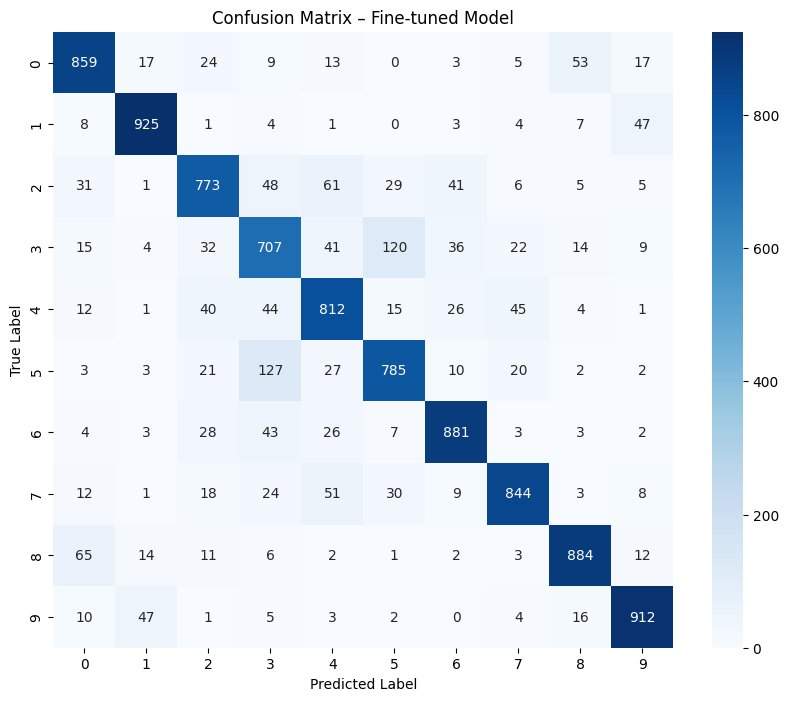

In [19]:
# %% Cell 10: Post‑analysis: Compute and display the confusion matrix for the fine‑tuned model
#
# We compute predictions for the fine‑tuned model on the entire test set and then
# display a confusion matrix using seaborn.
all_preds = []
all_true = []

pretrained_model.eval()
with torch.no_grad():
    for inputs, labels in testloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, _ = pretrained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Fine‑tuned Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Analysis:
# - The confusion matrix shows which classes are most often confused.
# - For example, you might observe that certain similar classes (like cats vs. dogs)
#   are sometimes misclassified.
# - Fine‑tuning helped boost the overall accuracy compared to the simple CNN.


In [20]:
# %% Cell 11: Define a function to log embeddings to TensorBoard
#
# This function logs multiple embeddings to TensorBoard's embedding projector.
# For each embedding (a 2D tensor of shape [num_samples, embedding_dim]),
# it logs the embedding along with optional metadata (labels).
def log_embeddings(writer, embeddings_dict, metadata_dict, global_step=0):
    """
    Logs embeddings to TensorBoard.

    Parameters:
      writer (SummaryWriter): TensorBoard writer.
      embeddings_dict (dict): A dictionary where keys are model names (str)
                              and values are embeddings (torch.Tensor of shape [N, D]).
      metadata_dict (dict): A dictionary where keys are model names (str)
                            and values are lists of metadata strings for each sample.
      global_step (int): Global training step (for TensorBoard).
    """
    for name, emb in embeddings_dict.items():
        # .add_embedding expects a 2D tensor and an optional metadata list
        writer.add_embedding(emb, metadata=metadata_dict.get(name, None),
                             tag=name, global_step=global_step)
    print("Embeddings logged to TensorBoard.")


In [24]:
# %% Cell 12: Prepare embeddings from custom, pre‑trained (frozen), and fine‑tuned models and log them
#
# For speed we use only the first 500 test samples from each model.
# Note: Since the models use different input transformations,
# the embeddings come from different networks.
#
# We prepare metadata (the true label for each sample) as a list of strings.
# Then, we log these embeddings using TensorBoard.
num_samples = 500

# For the custom model (simple CNN), we already have embeddings and labels (from Cell 4)
embeddings_custom_np = embeddings_custom.cpu()  # shape: [num_samples, embedding_dim]
metadata_custom = [str(label.item()) for label in labels_custom]

# For the pre‑trained (frozen) model, we have embeddings from Cell 7
embeddings_pretrained_np = embeddings_pretrained_frozen.cpu()  # shape: [num_samples, embedding_dim]
metadata_pretrained = [str(label.item()) for label in labels_pretrained]

# For the fine‑tuned model, we have embeddings from Cell 9
embeddings_finetuned_np = embeddings_finetuned.cpu()  # shape: [num_samples, embedding_dim]
metadata_finetuned = [str(label.item()) for label in labels_finetuned]

# Create a dictionary of embeddings and metadata
embeddings_dict = {
    "custom": embeddings_custom_np,
    "pretrained": embeddings_pretrained_np,
    "finetuned": embeddings_finetuned_np
}
metadata_dict = {
    "custom": metadata_custom,
    "pretrained": metadata_pretrained,
    "finetuned": metadata_finetuned
}

# Create a TensorBoard SummaryWriter (logs will be saved in the 'runs/embeddings' directory)
log_dir = "runs/embeddings"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir)

# Log the embeddings (global_step can be set to any value; here we use 0)
log_embeddings(writer, embeddings_dict, metadata_dict, global_step=0)
writer.close()

print("\nTo visualize the embeddings, run in a terminal:\n\n tensorboard --logdir=runs/embeddings\n")


Embeddings logged to TensorBoard.

To visualize the embeddings, run in a terminal:

 tensorboard --logdir=runs/embeddings



In [26]:
#%load_ext tensorboard
#%tensorboard --logdir=runs/embeddings

### other models!

In [27]:
import torchvision.models as models

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Print only the top-level layer names using named_children()
print("Top-level layers in ResNet18:")
for name, layer in model.named_children():
    print(name)

# Alternatively, if you want to print all modules (including nested ones),
# you can use named_modules().
print("\nAll layers (including nested ones) in ResNet18:")
for name, module in model.named_modules():
    # This prints the name (which may be empty for the top model) and the module type.
    # Filtering out the top-level (empty name) if desired.
    if name:  # only print non-empty names
        print(name)


/Users/steveschmidt/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/steveschmidt/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Top-level layers in ResNet18:
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc

All layers (including nested ones) in ResNet18:
conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.con

In [28]:
# %% Cell X: Build a pre‑trained ResNet18 model with a custom classifier head
#
# COMMENTS:
# - We load a pre‑trained ResNet18 model from torchvision.
# - Unlike MobileNetV2 (which has a 'features' submodule and a 'classifier'),
#   ResNet18’s architecture is organized with convolutional layers (conv1, bn1, relu, maxpool, layer1–layer4)
#   followed by a global average pooling (avgpool) and a final fully connected layer (fc).
# - We freeze all parameters except those of the final fully connected layer.
# - We then replace the fc layer with a new linear layer for 10 classes.
# - To extract an embedding, we manually replicate the forward pass up to the avgpool layer,
#   flatten the tensor, and then apply the new fc layer to obtain logits.
#
# Note: The input transform for ResNet18 should match ImageNet normalization and typically a size of 224x224.

from torchvision.models import resnet18

# Load the pre-trained ResNet18 model
resnet = resnet18(pretrained=True)

# Freeze all parameters first
for param in resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to output 10 classes.
# Also, unfreeze the new fc layer so that it can be trained.
num_features = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_features, 10)  # New classifier head

# Define a custom wrapper to return both logits and the embedding (features before the fc layer)
class PretrainedResNet18(nn.Module):
    def __init__(self, base_model):
        super(PretrainedResNet18, self).__init__()
        self.base_model = base_model
        
    def forward(self, x):
        # Manually perform the forward pass to extract intermediate features.
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)
        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        x = self.base_model.avgpool(x)
        # Flatten the output of avgpool to get the embedding.
        embedding = torch.flatten(x, 1)
        # Pass the embedding through the classifier (fc layer) to get logits.
        logits = self.base_model.fc(embedding)
        return logits, embedding

# Wrap the ResNet18 model and move it to the device.
pretrained_resnet18 = PretrainedResNet18(resnet).to(device)

# Define loss function and optimizer (only parameters with requires_grad=True are updated)
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(filter(lambda p: p.requires_grad, pretrained_resnet18.parameters()), lr=0.001)

print("Pre‑trained ResNet18 model ready for training (classifier head unfrozen).")


Pre‑trained ResNet18 model ready for training (classifier head unfrozen).


In [29]:
# %% Cell Y: Build a pre‑trained VGG16 model with a custom classifier head
#
# COMMENTS:
# - We load a pre‑trained VGG16 model from torchvision.
# - VGG16’s architecture is divided into 'features' (a stack of convolutional layers)
#   and 'classifier' (fully connected layers).
# - We freeze the feature extractor (vgg.features) and replace the classifier with a new one for CIFAR‑10.
# - In this example, we create a simpler classifier:
#     • A linear layer that reduces the flattened features (of size 25088) to a 64-dimensional embedding.
#     • A ReLU activation.
#     • A Dropout layer.
#     • A final linear layer mapping the 64-dimensional embedding to 10 classes.
# - The custom wrapper’s forward() method extracts the embedding from the first part of the classifier
#   and then obtains logits from the rest.
#
# Note: The input transform for VGG16 should use ImageNet normalization and a size of 224x224.

from torchvision.models import vgg16

# Load the pre-trained VGG16 model
vgg = vgg16(pretrained=True)

# Freeze the feature extractor (all layers in vgg.features)
for param in vgg.features.parameters():
    param.requires_grad = False

# Replace the classifier head.
# The original VGG16 classifier is a multi-layer fully connected network.
# We create a new classifier that first reduces dimensionality to obtain a compact embedding,
# then outputs the 10 classes.
vgg.classifier = nn.Sequential(
    nn.Linear(25088, 64),   # New linear layer to get a 64-dim embedding.
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(64, 10)       # Final classifier layer for 10 classes.
)

# Define a custom wrapper to return both logits and the embedding.
class PretrainedVGG16(nn.Module):
    def __init__(self, base_model):
        super(PretrainedVGG16, self).__init__()
        self.base_model = base_model
        
    def forward(self, x):
        # Pass input through the feature extractor (convolutional layers).
        x = self.base_model.features(x)
        # Flatten the output for the classifier.
        x = torch.flatten(x, 1)
        # Get the embedding by passing through the first linear layer and ReLU.
        embedding = self.base_model.classifier[0](x)  # Linear transformation (25088 -> 64)
        embedding = self.base_model.classifier[1](embedding)  # ReLU activation
        # Then pass the embedding through the remaining layers (Dropout and Linear) to get logits.
        logits = self.base_model.classifier[2:](embedding)
        return logits, embedding

# Wrap the VGG16 model and move it to the device.
pretrained_vgg16 = PretrainedVGG16(vgg).to(device)

# Define loss function and optimizer (only parameters with requires_grad=True will be updated)
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(filter(lambda p: p.requires_grad, pretrained_vgg16.parameters()), lr=0.001)

print("Pre‑trained VGG16 model ready for training (classifier head unfrozen, features frozen).")


/Users/steveschmidt/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/steveschmidt/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|███████████████████████████████████████████████████| 528M/528M [00:14<00:00, 37.2MB/s]


Pre‑trained VGG16 model ready for training (classifier head unfrozen, features frozen).
